In [ ]:
#!pip install sentence-transformers
#!pip install pandasgui

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/983.9 kB ? eta -:--:--
     ------------------------------------- 983.9/983.9 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasgui: filename=pandasgui-0.2.15-py3-none-any.whl size=235519 sha256=c889c55d7a24fbab84721566d277ded07214335501d385bee3f6ff97344d5019
  Stored in directory: c:\users\marlo\appdata\local\pip\cache\wheels\20\3d\f8\821f3ab82c2c6b5a717b760e2ea07f90ad4321dc0f7ffedcb1
  Created wheel for qtstylish: filename=qtstylish-0.1.5-py3-none-any.whl size=1029358 sha256=919fdf9ff3937eeed38fb3d72beb4ede2253f5042a0bc8bbeb23f7861f685a6a
  Stored in directory: c:\users\marlo\appdata\local\pip\cache\wheels\33\6f\1a\cd829ecf5647f0b31adeeea886b6f12f356156c615702eb1ab
Successfully built pandasgui qtstylish


In [2]:
import os
import numpy as np
import pandas as pd
import pandasgui as pdg
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re, unicodedata
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# set directories
working_dir = r"C:\Users\marlo\Documents\PhDEQUALFIN"
allocation_dir = os.path.join(working_dir, "Chapter_1_Allocation")
godad_data_dir = os.path.join(working_dir, "Datasets", "GODAD Final Data")
rio_data_dir = os.path.join(working_dir, "Datasets", "RioMarkers data")
geoepr_data_dir = os.path.join(working_dir, "Datasets", "GeoEPR-2021")
plad_data_dir = os.path.join(working_dir, "Datasets", "PLAD")
world_dir = os.path.join(working_dir, "Datasets", "Political_Boundaries__States_and_Provinces")

In [4]:
# 1. Load (replace with your real file paths)
godad = pd.read_stata(f"{godad_data_dir}\\GODAD_projectlevel_eu_us.dta")
rio = pd.read_stata(f"{rio_data_dir}\\riomarkers200223_redux.dta")

In [5]:
rio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567350 entries, 0 to 10567349
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   year               int16  
 1   donornamee         object 
 2   recipientnamee     object 
 3   score              int8   
 4   environment        float64
 5   biodiversity       float64
 6   climatemitigation  float64
 7   climateadaptation  float64
 8   desertification    float64
 9   sector             int16  
 10  projecttitle       object 
dtypes: float64(5), int16(2), int8(1), object(3)
memory usage: 695.4+ MB


In [6]:
godad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347195 entries, 0 to 347194
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   project_id                  347195 non-null  object 
 1   project_location_id         347195 non-null  object 
 2   donor                       347195 non-null  object 
 3   gid_0                       347195 non-null  object 
 4   gid_1                       347195 non-null  object 
 5   gid_2                       347195 non-null  object 
 6   name_0                      347195 non-null  object 
 7   name_1                      347195 non-null  object 
 8   name_2                      347195 non-null  object 
 9   latitude                    344047 non-null  float64
 10  longitude                   344047 non-null  float64
 11  startyear                   265962 non-null  float64
 12  closingyear                 255479 non-null  float64
 13  paymentyear   

In [4]:
# 2. Basic text cleaning
def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = unicodedata.normalize("NFKD", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [8]:
# clean string variables in godad and rio
godad["title_clean"] = godad["projecttitle"].map(clean_text)
godad["donor_clean"] = godad["donor"].map(clean_text)
godad["recipient_clean"] = godad["name_0"].map(clean_text)

In [9]:
rio["title_clean"] = rio["projecttitle"].map(clean_text)
rio["donor_clean"] = rio["donornamee"].map(clean_text)
rio["recipient_clean"] = rio["recipientnamee"].map(clean_text)

### Deduplicate Rio by title
Some Rio records have identical cleaned titles. Before blocking, we concatenate these duplicates into a single row per title, and keep multiple distinct values for the marker fields (e.g., `environment`, `environment2`, `environment3`).

In [10]:

# Helper to build a robust block key
def build_block_key(df, recipient_col, donor_col, sector_col):
    return (
        df[recipient_col].fillna("").astype(str) + "|" +
        df[donor_col].fillna("").astype(str) + "|" +
        df[sector_col].fillna("").astype(str)
    )

# (Optional) clean sector numeric like 123.0 -> 123
def tidy_sector_series(s):
    s = s.fillna("").astype(str)
    return s.str.replace(r"\.0$", "", regex=True)

godad["sector_codes_str"] = tidy_sector_series(godad["sector_codes"])
rio["sector_str"] = tidy_sector_series(rio["sector"])

godad["block_key"] = (
    godad["recipient_clean"].fillna("") + "|" +
    godad["donor_clean"].fillna("") + "|" +
    godad["sector_codes_str"]
)

rio["block_key"] = (
    rio["recipient_clean"].fillna("") + "|" +
    rio["donor_clean"].fillna("") + "|" +
    rio["sector_str"]
)

# (Optional) remove accidental double separators like '||'
godad["block_key"] = godad["block_key"].str.replace(r"\|{2,}", "|", regex=True).str.strip("|")
rio["block_key"] = rio["block_key"].str.replace(r"\|{2,}", "|", regex=True).str.strip("|")

# Sanity check
print(godad[["recipient_clean","donor_clean","sector_codes","block_key"]].head())
print(rio[["recipient_clean","donor_clean","sector","block_key"]].head())

   recipient_clean donor_clean sector_codes                    block_key
0       cape verde     austria          430       cape verde|austria|430
1       cape verde     austria          113       cape verde|austria|113
2  north macedonia     austria          140  north macedonia|austria|140
3  north macedonia     austria          232  north macedonia|austria|232
4       cape verde     austria          430       cape verde|austria|430
  recipient_clean donor_clean  sector                  block_key
0     afghanistan   australia     112  afghanistan|australia|112
1     afghanistan   australia     720  afghanistan|australia|720
2     afghanistan   australia     151  afghanistan|australia|151
3     afghanistan   australia     720  afghanistan|australia|720
4     afghanistan   australia     720  afghanistan|australia|720
  recipient_clean donor_clean  sector                  block_key
0     afghanistan   australia     112  afghanistan|australia|112
1     afghanistan   australia     720  afg

In [11]:
# --- Concatenate duplicate Rio projects by title before blocking ---
# For rows in 'rio' with identical title_clean, we keep one row and expand marker fields
# to include distinct values as extra columns (e.g., environment, environment2, ...).

marker_cols = [
    "score",
    "environment",
    "biodiversity",
    "climatemitigation",
    "climateadaptation",
    "desertification",
]

# Helper: collect unique non-null values, preserving order
from collections import OrderedDict

def unique_vals(series):
    vals = [v for v in series.tolist() if pd.notna(v)]
    # preserve order while removing duplicates
    seen = OrderedDict()
    for v in vals:
        if v not in seen:
            seen[v] = True
    return list(seen.keys())

# Group by cleaned title and collapse
agg_frames = []
for title, grp in rio.groupby("title_clean", dropna=False):
    base = grp.iloc[0].copy()
    # Expand marker columns into multiple numbered columns when needed
    for col in marker_cols:
        uv = unique_vals(grp[col]) if col in grp.columns else []
        # ensure at least one position exists (even if empty)
        if len(uv) == 0:
            base[col] = pd.NA
        else:
            base[col] = uv[0]
            # add additional columns: col2, col3, ... if present
            for k, v in enumerate(uv[1:], start=2):
                base[f"{col}{k}"] = v
    # Optionally, you can also merge donors/recipients if they differ across dups
    agg_frames.append(base)

rio_dedup = pd.DataFrame(agg_frames)

# Rebuild block_key on the deduped rio
rio_dedup["sector_str"] = tidy_sector_series(rio_dedup.get("sector", pd.Series(index=rio_dedup.index)))
rio_dedup["recipient_clean"] = rio_dedup["recipient_clean"].fillna("")
rio_dedup["donor_clean"] = rio_dedup["donor_clean"].fillna("")
rio_dedup["block_key"] = (
    rio_dedup["recipient_clean"] + "|" + rio_dedup["donor_clean"] + "|" + rio_dedup["sector_str"]
)
rio_dedup["block_key"] = rio_dedup["block_key"].str.replace(r"\|{2,}", "|", regex=True).str.strip("|")

# Use deduped Rio for the rest of the pipeline
rio = rio_dedup

print("Rio rows before:", len(rio_dedup))  # note: printed after reassignment, but okay
print("Unique titles:", rio["title_clean"].nunique())

Rio rows before: 716075
Unique titles: 716075


In [12]:
# 3. blocking: only compare records from the same country
#   This prevents comparing totally unrelated countries.
block_keys = sorted(set(godad["block_key"]) & set(rio["block_key"])) # set(godad["block_key"]) gets all unique block keys from the godad dataset. & operator finds the intersection: only block keys that appear in both datasets.
for key in block_keys: # loop goes through each shared block key.
    godad_block = godad[godad["block_key"] == key] # For the current block key, this selects all rows from godad that have this block key.
    rio_block = rio[rio["block_key"] == key] # Same for rio: selects all rows from rio that have this block key.

In [13]:
block_keys

['afghanistan|austria|111',
 'afghanistan|austria|112',
 'afghanistan|austria|151',
 'afghanistan|austria|152',
 'afghanistan|austria|160',
 'afghanistan|belgium|111',
 'afghanistan|belgium|112',
 'afghanistan|belgium|113',
 'afghanistan|belgium|151',
 'afghanistan|belgium|152',
 'afghanistan|belgium|311',
 'afghanistan|belgium|720',
 'afghanistan|belgium|730',
 'afghanistan|denmark|111',
 'afghanistan|denmark|112',
 'afghanistan|denmark|122',
 'afghanistan|denmark|151',
 'afghanistan|denmark|152',
 'afghanistan|denmark|160',
 'afghanistan|denmark|250',
 'afghanistan|denmark|311',
 'afghanistan|denmark|430',
 'afghanistan|denmark|720',
 'afghanistan|denmark|730',
 'afghanistan|finland|111',
 'afghanistan|finland|112',
 'afghanistan|finland|113',
 'afghanistan|finland|121',
 'afghanistan|finland|122',
 'afghanistan|finland|130',
 'afghanistan|finland|151',
 'afghanistan|finland|152',
 'afghanistan|finland|160',
 'afghanistan|finland|410',
 'afghanistan|finland|720',
 'afghanistan|france

In [14]:
# 4. Load embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

matches = []
threshold = 0.80

for key in block_keys:
    godad_block = godad[godad["block_key"] == key]
    rio_block = rio[rio["block_key"] == key]
    if godad_block.empty or rio_block.empty:
        continue

    godad_vecs = model.encode(godad_block.title_clean.tolist(), normalize_embeddings=True)
    rio_vecs = model.encode(rio_block.title_clean.tolist(), normalize_embeddings=True)

    sim = cosine_similarity(godad_vecs, rio_vecs)

    for i, godad_row in enumerate(godad_block.itertuples()):
        j_best = sim[i].argmax()
        score = sim[i, j_best]
        if score >= threshold:
            rio_idx = rio_block.index[j_best]
            rio_row = rio_block.iloc[j_best]
            matches.append({
                "godad_id": godad_row.Index,
                "rio_id": rio_idx,
                "block_key": key,
                "similarity": float(score)
            })

# Build initial match DataFrame
result = pd.DataFrame(matches)

# Merge in ALL godad columns (avoid duplicating block_key)
godad_full = godad.reset_index().rename(columns={'index': 'godad_id'})
godad_full = godad_full.drop(columns=["block_key"], errors="ignore")  # prevent _x/_y creation
result = result.merge(godad_full, on="godad_id", how="left")

# Select requested rio columns
rio_cols_needed = ["projecttitle", "score","environment","biodiversity",
                   "climatemitigation","climateadaptation","desertification",
                   # also include expanded columns if they exist
                   "score2","score3","environment2","environment3","biodiversity2","biodiversity3",
                   "climatemitigation2","climatemitigation3","climateadaptation2","climateadaptation3","desertification2","desertification3"]
missing = [c for c in rio_cols_needed if c not in rio.columns]
if missing:
    print("Missing rio columns (ok if not all exist):", missing)

rio_sel = rio.reset_index().rename(columns={'index': 'rio_id'})
rio_sel = rio_sel[["rio_id"] + [c for c in rio_cols_needed if c in rio_sel.columns]]

result = result.merge(rio_sel, on="rio_id", how="left", suffixes=("", "_rio"))

# Ensure a single block_key column (in case of earlier duplication)
if "block_key_x" in result.columns and "block_key" not in result.columns:
    result["block_key"] = result["block_key_x"]
elif "block_key_y" in result.columns and "block_key" not in result.columns:
    result["block_key"] = result["block_key_y"]

# Build ordered column list safely
core_cols = ["godad_id","rio_id","similarity"]
if "block_key" in result.columns:
    core_cols.append("block_key")

# Append remaining columns preserving order
remaining = [c for c in result.columns if c not in core_cols]
result = result[core_cols + remaining]

print(result.head())
print(result.info())

   godad_id   rio_id  similarity                block_key project_id  \
0       405  9674910         1.0  afghanistan|austria|111     AFG_62   
1       389  9939162         1.0  afghanistan|austria|112     AFG_84   
2       395  8547245         1.0  afghanistan|austria|112    AFG_150   
3       388  9674927         1.0  afghanistan|austria|151     AFG_68   
4       406  7788345         1.0  afghanistan|austria|151     AFG_96   

  project_location_id    donor gid_0     gid_1        gid_2  ... environment2  \
0           AFG_62_01  Austria   AFG  AFG.22_1  AFG.22.11_1  ...          NaN   
1           AFG_84_01  Austria   AFG  AFG.14_1   AFG.14.3_1  ...          NaN   
2          AFG_150_01  Austria   AFG  AFG.14_1   AFG.14.3_1  ...          NaN   
3           AFG_68_01  Austria   AFG  AFG.14_1   AFG.14.3_1  ...          NaN   
4           AFG_96_01  Austria   AFG  AFG.23_1   AFG.23.1_1  ...          NaN   

  environment3 biodiversity2  biodiversity3  climatemitigation2  \
0          Na

In [15]:
result.describe()

,godad_id,rio_id,similarity,latitude,longitude,startyear,closingyear,paymentyear,precision_code,location_count,...,environment2,environment3,biodiversity2,biodiversity3,climatemitigation2,climatemitigation3,climateadaptation2,climateadaptation3,desertification2,desertification3
count,225486.000000,2.254860e+05,225486.000000,225299.000000,225299.000000,173261.000000,178312.000000,225486.000000,223073.000000,225299.000000,...,7197.000000,608.000000,3050.000000,198.000000,2757.000000,63.000000,3145.000000,133.000000,1758.000000,105.000000
mean,176676.656502,5.673691e+06,0.986600,8.119303,9.608541,2013.420539,2014.475453,2013.168489,11.727331,2.396615,...,0.795887,1.159539,0.840000,1.520202,0.808125,1.174603,0.841971,1.203008,0.701934,1.523810
std,97539.008310,2.625637e+06,0.036970,18.402778,59.014735,7.674970,9.021584,4.981650,0.693808,8.730263,...,0.762259,0.673730,0.713897,0.520734,0.741546,0.684852,0.779521,0.660112,0.655876,0.501828
min,3.000000,3.626300e+04,0.800006,-55.983334,-178.950958,1900.000000,1900.000000,1989.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,98758.250000,3.879500e+06,1.000000,-4.377542,-43.790844,2012.000000,2011.000000,2009.000000,12.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,177351.500000,5.833634e+06,1.000000,9.270965,27.854033,2015.000000,2016.000000,2014.000000,12.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
75%,256153.750000,7.949201e+06,1.000000,18.580145,40.958687,2018.000000,2019.000000,2017.000000,12.000000,2.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
max,347194.000000,1.056734e+07,1.000001,55.484581,179.473038,2023.000000,2060.000000,2023.000000,12.000000,239.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [16]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225486 entries, 0 to 225485
Data columns (total 92 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   godad_id                    225486 non-null  int64  
 1   rio_id                      225486 non-null  int64  
 2   similarity                  225486 non-null  float64
 3   block_key                   225486 non-null  object 
 4   project_id                  225486 non-null  object 
 5   project_location_id         225486 non-null  object 
 6   donor                       225486 non-null  object 
 7   gid_0                       225486 non-null  object 
 8   gid_1                       225486 non-null  object 
 9   gid_2                       225486 non-null  object 
 10  name_0                      225486 non-null  object 
 11  name_1                      225486 non-null  object 
 12  name_2                      225486 non-null  object 
 13  latitude      

In [17]:
result.shape

(225486, 92)

In [18]:
godad.shape

(347195, 70)

In [19]:
result.to_csv(f"{allocation_dir}\\godad_rio_aimerge.csv", index=False)
godad_full.to_csv(f"{allocation_dir}\\godad_incl_id.csv", index=False)
rio_sel.to_csv(f"{allocation_dir}\\rio_incl_id.csv", index=False)

In [20]:
godad_full

,godad_id,project_id,project_location_id,donor,gid_0,gid_1,gid_2,name_0,name_1,name_2,...,comm_nominal_loc_evensplit,disb_nominal_loc_evensplit,precision_crs,env_crs,projecttitle,projecttitle_lower,title_clean,donor_clean,recipient_clean,sector_codes_str
0,0,193761.0,193761.0_01,Austria,CPV,CPV.21_1,,Cape Verde,Tarrafal,,...,565622.0,0.0,4.0,0.0,UNTERST▄TZUNG DER GEMEINDEEIGENEN VER- UND ENT...,unterst▄tzung der gemeindeeigenen ver- und ent...,unterst tzung der gemeindeeigenen ver und ents...,austria,cape verde,430
1,1,193758.0,193758.0_01,Austria,CPV,CPV.3_1,,Cape Verde,Maio,,...,212986.0,127816.0,3.0,0.0,ALPHABETISIERUNG UND BASISBERUFSBILDUNG CALHETA,alphabetisierung und basisberufsbildung calheta,alphabetisierung und basisberufsbildung calheta,austria,cape verde,113
2,2,209528.0,209528.0_01,Austria,MKD,MKD.46_1,,North Macedonia,Makedonski Brod,,...,57049.0,0.0,4.0,0.0,SEWERAGE SYSTEM MAKEDONSKI BROD,sewerage system makedonski brod,sewerage system makedonski brod,austria,north macedonia,140
3,3,209526.0,209526.0_01,Austria,MKD,MKD.35_1,,North Macedonia,Kočani,,...,423512.0,0.0,4.0,0.0,GEOTHERMAL ENERGY SYSTEM IN KOCANI,geothermal energy system in kocani,geothermal energy system in kocani,austria,north macedonia,232
4,4,193761.0,193761.0_01,Austria,CPV,CPV.21_1,,Cape Verde,Tarrafal,,...,0.0,243136.0,4.0,0.0,UNTERST▄TZUNG DER GEMEINDEEIGENEN VER- UND ENT...,unterst▄tzung der gemeindeeigenen ver- und ent...,unterst tzung der gemeindeeigenen ver und ents...,austria,cape verde,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347190,347190,3758294.0,3758294.0_02,United States,ZWE,ZWE.9_1,ZWE.9.6_1,Zimbabwe,Matabeleland South,Matobo,...,0.0,319605.0,3.0,0.0,DCHA/OFDA Grant for Zimbabwe/Drought-2016,dcha/ofda grant for zimbabwe/drought-2016,dcha ofda grant for zimbabwe drought 2016,united states,zimbabwe,720
347191,347191,3758392.0,3758392.0_01,United States,ZWE,ZWE.9_1,ZWE.9.6_1,Zimbabwe,Matabeleland South,Matobo,...,0.0,0.0,3.0,1.0,Matobo National Park: annual darting and immob...,matobo national park: annual darting and immob...,matobo national park annual darting and immobi...,united states,zimbabwe,410
347192,347192,3758391.0,3758391.0_01,United States,ZWE,ZWE.9_1,ZWE.9.6_1,Zimbabwe,Matabeleland South,Matobo,...,21410.0,0.0,3.0,1.0,Matobo National Park: annual darting and immob...,matobo national park: annual darting and immob...,matobo national park annual darting and immobi...,united states,zimbabwe,410
347193,347193,3758726.0,3758726.0_02,United States,ZWE,ZWE.9_1,ZWE.9.6_1,Zimbabwe,Matabeleland South,Matobo,...,0.0,160880.0,3.0,0.0,DCHA/OFDA Grant for Zimbabwe/Drought-2016,dcha/ofda grant for zimbabwe/drought-2016,dcha ofda grant for zimbabwe drought 2016,united states,zimbabwe,720


### Try AI-based approach to Infer on Rio Marker based on Project Title and Long Description

# Goal
We’ll train simple text classifiers that predict Rio Markers (0/1/2) from project descriptions.

High-level steps:
- Build a labeled training set from rows where Rio Markers exist.
- Turn text into numeric features using TF‑IDF (a classic, fast baseline).
- Train one model per marker (environment, biodiversity, climate mitigation, climate adaptation, desertification) to predict 0/1/2.
- Evaluate on a validation split, then predict for all remaining projects without labels.
- Save predictions to CSV and save models for later reuse.

This is a lightweight, beginner‑friendly baseline that you can improve later (e.g., try transformer models).

In [6]:
# --- Setup: text column and label frame ---
# Assumptions:
# - 'result' contains matched rows with Rio Marker columns present for some subset.
# - We will use 'title_clean' as the main text feature. If you also have descriptions, you can combine them.

import numpy as np
import pandas as pd

result = pd.read_csv(f"{allocation_dir}\\godad_rio_aimerge.csv")
result["description_clean"] = result["description"].map(clean_text)

result["title_desc"] = (
    result["title_clean"].fillna("") + " " + result["description_clean"].fillna("")
)

# Choose your text column(s). If you have a description column, combine it here.
TEXT_COL = "title_desc"  # change to e.g., 'title_clean_desc' if you concatenate title+description

# Make sure we have a training frame with labels present
LABEL_COLS = [
    "environment",
    "biodiversity",
    "climatemitigation",
    "climateadaptation",
    "desertification",
]

# Keep rows where at least one label is non-null
has_any_label = result[LABEL_COLS].notna().any(axis=1)
train_df = result.loc[has_any_label].copy()

# Optional: if you want to require all labels present for training, use .notna().all(axis=1) instead
# has_all_labels = result[LABEL_COLS].notna().all(axis=1)
# train_df = result.loc[has_all_labels].copy()

# Fill missing text with empty string to be safe
train_df[TEXT_COL] = train_df[TEXT_COL].fillna("")

print(f"Training rows with at least one label: {len(train_df)}")
train_df[LABEL_COLS].describe(include="all")

C:\Users\marlo\AppData\Local\Temp\ipykernel_18716\3244124626.py:9: DtypeWarning: Columns (4,19,32,52,53,55) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(f"{allocation_dir}\\godad_rio_aimerge.csv")


Training rows with at least one label: 211129


,environment,biodiversity,climatemitigation,climateadaptation,desertification
count,209148.000000,187432.000000,185159.000000,152045.000000,159271.000000
mean,0.486875,0.201086,0.123991,0.208287,0.095121
std,0.728684,0.519701,0.397821,0.493964,0.330859
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,2.000000,3.000000


In [12]:
# --- Train/evaluate one model per marker (0/1/2 classification) ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import joblib, os

models = {}
reports = {}
RANDOM_STATE = 42
os.makedirs(os.path.join(allocation_dir, "models"), exist_ok=True)

for label in LABEL_COLS:
    # Filter rows where this specific label is present
    df_lab = train_df.dropna(subset=[label]).copy()
    # Exclude any desertification == 3 from training (out-of-scope value)
    if label == "desertification":
        before = len(df_lab)
        df_lab = df_lab[df_lab[label] != 3]
        removed = before - len(df_lab)
        if removed > 0:
            print(f"Excluded {removed} row(s) where desertification == 3 from training.")
    print(f"\n=== Training for label: {label} ===")
    print(f"Rows with label used: {len(df_lab)}")
    if len(df_lab) < 20:
        print("Too few labeled examples; skipping this label.")
        continue
    X = df_lab[TEXT_COL].values
    y = df_lab[label].astype(int).values  # 0/1/2 expected
    # Check class counts and handle rare classes
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print("Class counts:", class_counts)
    if any(c < 2 for c in counts):
        print("One or more classes have fewer than 2 samples; skipping stratified split.")
        if len(y) < 10:
            print("Too few samples overall; skipping this label.")
            continue
        stratify_arg = None
    else:
        stratify_arg = y
    # Train/validation split
    try:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_arg)
    except ValueError as e:
        print("Stratified split failed:", e)
        print("Falling back to non-stratified split.")
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None)
    # Compute class weights to help with imbalance (use only classes in y_train)
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    cw_dict = {c: w for c, w in zip(classes, class_weights)}
    # Build a simple pipeline: TF-IDF -> Logistic Regression (multiclass)
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000)),
        ("clf", LogisticRegression(multi_class="ovr", class_weight=cw_dict, max_iter=200, n_jobs=None, random_state=RANDOM_STATE)),
    ])
    pipe.fit(X_train, y_train)
    # Evaluate
    y_pred = pipe.predict(X_val)
    print(classification_report(y_val, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
    models[label] = pipe
    reports[label] = classification_report(y_val, y_pred, output_dict=True)
    # Save model for later reuse
    model_path = os.path.join(allocation_dir, "models", f"tfidf_logreg_{label}.joblib")
    joblib.dump(pipe, model_path)
    print(f"Saved: {model_path}")
print("\nDone training.")


=== Training for label: environment ===
Rows with label used: 209148
Class counts: {0: 136720, 1: 43027, 2: 29401}


c:\Users\marlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.942     0.863     0.901     27344
           1      0.655     0.775     0.710      8606
           2      0.762     0.858     0.807      5880

    accuracy                          0.844     41830
   macro avg      0.787     0.832     0.806     41830
weighted avg      0.858     0.844     0.848     41830

Confusion matrix:
 [[23585  2950   809]
 [ 1169  6672   765]
 [  275   562  5043]]
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_environment.joblib
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_environment.joblib

=== Training for label: biodiversity ===
Rows with label used: 187432
Class counts: {0: 159998, 1: 17178, 2: 10256}

=== Training for label: biodiversity ===
Rows with label used: 187432
Class counts: {0: 159998, 1: 17178, 2: 10256}


c:\Users\marlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.986     0.901     0.942     32000
           1      0.504     0.861     0.636      3436
           2      0.782     0.906     0.840      2051

    accuracy                          0.898     37487
   macro avg      0.758     0.890     0.806     37487
weighted avg      0.931     0.898     0.908     37487

Confusion matrix:
 [[28846  2779   375]
 [  335  2959   142]
 [   64   129  1858]]
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_biodiversity.joblib
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_biodiversity.joblib

=== Training for label: climatemitigation ===
Rows with label used: 185159
Class counts: {0: 166797, 1: 13766, 2: 4596}

=== Training for label: climatemitigation ===
Rows with label used: 185159
Class counts: {0: 166797, 1: 13766, 2: 4596}


c:\Users\marlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.989     0.909     0.948     33360
           1      0.481     0.864     0.618      2753
           2      0.586     0.909     0.712       919

    accuracy                          0.906     37032
   macro avg      0.685     0.894     0.759     37032
weighted avg      0.941     0.906     0.917     37032

Confusion matrix:
 [[30332  2523   505]
 [  289  2378    86]
 [   44    40   835]]
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_climatemitigation.joblib
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_climatemitigation.joblib

=== Training for label: climateadaptation ===
Rows with label used: 152045
Class counts: {0: 126389, 1: 19643, 2: 6013}

=== Training for label: climateadaptation ===
Rows with label used: 152045
Class counts: {0: 126389, 1: 19643, 2: 6013}


c:\Users\marlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.983     0.892     0.935     25278
           1      0.597     0.858     0.704      3928
           2      0.603     0.924     0.730      1203

    accuracy                          0.889     30409
   macro avg      0.728     0.891     0.790     30409
weighted avg      0.918     0.889     0.897     30409

Confusion matrix:
 [[22539  2213   526]
 [  355  3369   204]
 [   30    62  1111]]
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_climateadaptation.joblib
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_climateadaptation.joblib
Excluded 1 row(s) where desertification == 3 from training.

=== Training for label: desertification ===
Rows with label used: 159270
Class counts: {0: 145983, 1: 11427, 2: 1860}
Excluded 1 row(s) where desertification == 3 from training.

=== Training for label: desertification ===
Rows with label used: 159270
Cla

c:\Users\marlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.991     0.909     0.948     29197
           1      0.457     0.881     0.602      2285
           2      0.477     0.863     0.614       372

    accuracy                          0.906     31854
   macro avg      0.642     0.884     0.721     31854
weighted avg      0.946     0.906     0.919     31854

Confusion matrix:
 [[26530  2364   303]
 [  223  2013    49]
 [   25    26   321]]
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_desertification.joblib

Done training.
Saved: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\models\tfidf_logreg_desertification.joblib

Done training.


In [13]:
# --- Predict for all projects and save outputs ---
import os, numpy as np, pandas as pd

# Ensure required globals exist or set sensible defaults
if 'TEXT_COL' not in globals():
    TEXT_COL = 'title_desc'
if 'LABEL_COLS' not in globals():
    LABEL_COLS = ['environment','biodiversity','climatemitigation','climateadaptation','desertification']
if 'models' not in globals() or len(models) == 0:
    raise RuntimeError('No trained models available. Run the training cell first.')

# Load GODAD if not present in memory
if 'godad' not in globals():
    godad_csv = os.path.join(allocation_dir, 'godad_incl_id.csv') if 'allocation_dir' in globals() else None
    if godad_csv and os.path.exists(godad_csv):
        godad = pd.read_csv(godad_csv)
    elif 'godad_data_dir' in globals():
        dta_path = f"{godad_data_dir}\\GODAD_projectlevel_eu_us.dta"
        if os.path.exists(dta_path):
            godad = pd.read_stata(dta_path)
        else:
            raise RuntimeError('Could not find GODAD data file. Run the data-loading cell first.')
    else:
        raise RuntimeError('GODAD dataset not loaded. Run the data-loading cell first.')

# Fallback clean_text if not defined (for out-of-order runs)
if 'clean_text' not in globals():
    import re, unicodedata
    def clean_text(s):
        if not isinstance(s, str): return ''
        s = s.lower()
        s = unicodedata.normalize('NFKD', s)
        s = re.sub(r'[^a-z0-9\s]', ' ', s)
        s = re.sub(r'\s+', ' ', s).strip()
        return s

# Ensure TEXT_COL exists on GODAD (build from title/description when needed)
if TEXT_COL not in godad.columns:
    if 'title_clean' not in godad.columns:
        if 'projecttitle' in godad.columns: godad['title_clean'] = godad['projecttitle'].map(clean_text)
        else: godad['title_clean'] = ''
    if 'description_clean' not in godad.columns:
        if 'description' in godad.columns: godad['description_clean'] = godad['description'].map(clean_text)
        else: godad['description_clean'] = ''
    godad['title_desc'] = godad['title_clean'].fillna('') + ' ' + godad['description_clean'].fillna('')

all_projects = godad.copy()
all_projects[TEXT_COL] = all_projects[TEXT_COL].fillna('')

# Add prediction columns
for label, pipe in models.items():
    if pipe is None: continue
    X_text = all_projects[TEXT_COL].values
    preds = pipe.predict(X_text)
    conf = pipe.predict_proba(X_text).max(axis=1) if hasattr(pipe, 'predict_proba') else np.nan
    all_projects[f'{label}_pred'] = preds
    all_projects[f'{label}_pred_conf'] = conf

# Optionally merge back actual labels (from result) for the matched subset
if 'result' in globals() and 'godad_id' in result.columns:
    comp_df = result[['godad_id'] + [c for c in LABEL_COLS if c in result.columns]].copy()
    # Ensure a single 'godad_id' column on left without duplicating it
    if 'godad_id' not in all_projects.columns:
        all_projects = all_projects.reset_index().rename(columns={'index': 'godad_id'})
    # Merge using existing or newly created 'godad_id'
    all_projects = all_projects.merge(comp_df, on='godad_id', how='left', suffixes=('', '_actual'))

# Save predictions
out_path = os.path.join(allocation_dir, 'godad_rio_predictions.csv')
all_projects.to_csv(out_path, index=False)
print(f'Saved predictions to: {out_path} (rows={len(all_projects)})')

Saved predictions to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\godad_rio_predictions.csv (rows=347195)


In [14]:
all_projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347195 entries, 0 to 347194
Data columns (total 87 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   godad_id                     347195 non-null  int64  
 1   project_id                   347195 non-null  object 
 2   project_location_id          344047 non-null  object 
 3   donor                        347195 non-null  object 
 4   gid_0                        347118 non-null  object 
 5   gid_1                        346975 non-null  object 
 6   gid_2                        340895 non-null  object 
 7   name_0                       345984 non-null  object 
 8   name_1                       345913 non-null  object 
 9   name_2                       339866 non-null  object 
 10  latitude                     344047 non-null  float64
 11  longitude                    344047 non-null  float64
 12  startyear                    265962 non-null  float64
 13 

## What to try next
- Add descriptions: if you have a longer description column, concatenate it with the title for better signals.
- Tune the model: try adjusting ngram_range, max_features, and LogisticRegression max_iter.
- Calibration: use predict_proba to set custom thresholds (e.g., treat class 2 only if confidence > 0.7).
- Transformer upgrade: later, replace TF‑IDF with a transformer (e.g., fine‑tune a small BERT) if you need more accuracy.
- Human spot-check: review a random sample of predictions and compare to actuals where available.

In [10]:
# Import the geoEPR shapefile
geoEPR_shapefile = gpd.read_file(f"{geoepr_data_dir}\\GeoEPR-2021.shp")


In [11]:
# Drop geometry column temporarily to view as regular DataFrame
geoepr_df = geoEPR_shapefile.drop(columns=['geometry'])
geoepr_df   # then right-click or use Variables pane on geoepr_df

,gwid,statename,from,to,group,groupid,gwgroupid,umbrella,sqkm,type
0,2,United States of America,1946,1958,Whites,1000,201000,NaN,7940038.0,Statewide
1,2,United States of America,1946,1958,African Americans,3000,203000,NaN,1037020.0,Regional & urban
2,2,United States of America,1946,1958,American Indians,5000,205000,NaN,939761.0,Regionally based
3,2,United States of America,1959,1959,Whites,1000,201000,NaN,7940038.0,Statewide
4,2,United States of America,1959,1959,African Americans,3000,203000,NaN,1037020.0,Regional & urban
...,...,...,...,...,...,...,...,...,...,...
1680,920,New Zealand,1996,2021,Asians,4000,92004000,NaN,0.0,Urban
1681,950,Fiji,1970,1970,Fijians,1000,95001000,NaN,18031.0,Statewide
1682,950,Fiji,1970,1970,Indians,2000,95002000,NaN,18031.0,Statewide
1683,950,Fiji,1971,2021,Fijians,1000,95001000,NaN,18031.0,Statewide


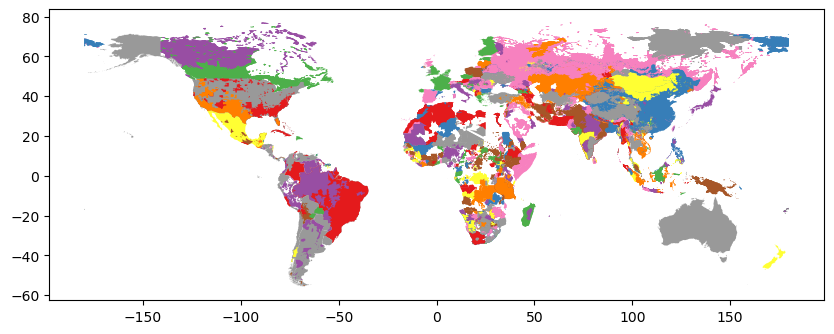

In [12]:
# draw the geoEPR_shapefile on a map, using different colors for the different groups, but without a legend
import matplotlib.pyplot as plt
geoEPR_shapefile.plot(column='group', cmap='Set1', figsize=(10,10), legend=False)
plt.show()

In [13]:
geoEPR_shapefile

,gwid,statename,from,to,group,groupid,gwgroupid,umbrella,sqkm,type,geometry
0,2,United States of America,1946,1958,Whites,1000,201000,NaN,7940038.0,Statewide,"MULTIPOLYGON (((-93.819 48.586, -93.805 48.532..."
1,2,United States of America,1946,1958,African Americans,3000,203000,NaN,1037020.0,Regional & urban,"MULTIPOLYGON (((-73.178 41.171, -73.157 41.291..."
2,2,United States of America,1946,1958,American Indians,5000,205000,NaN,939761.0,Regionally based,"MULTIPOLYGON (((-73.912 45, -73.864 44.819, -7..."
3,2,United States of America,1959,1959,Whites,1000,201000,NaN,7940038.0,Statewide,"MULTIPOLYGON (((-93.819 48.586, -93.805 48.532..."
4,2,United States of America,1959,1959,African Americans,3000,203000,NaN,1037020.0,Regional & urban,"MULTIPOLYGON (((-73.178 41.171, -73.157 41.291..."
...,...,...,...,...,...,...,...,...,...,...,...
1680,920,New Zealand,1996,2021,Asians,4000,92004000,NaN,0.0,Urban,None
1681,950,Fiji,1970,1970,Fijians,1000,95001000,NaN,18031.0,Statewide,"MULTIPOLYGON (((178.62 -16.836, 178.62 -16.836..."
1682,950,Fiji,1970,1970,Indians,2000,95002000,NaN,18031.0,Statewide,"MULTIPOLYGON (((178.62 -16.836, 178.62 -16.836..."
1683,950,Fiji,1971,2021,Fijians,1000,95001000,NaN,18031.0,Statewide,"MULTIPOLYGON (((178.62 -16.836, 178.62 -16.836..."


In [4]:
# import worldmap shapefile
world = gpd.read_file(f"{world_dir}\\Political_Boundaries%3A_States_and_Provinces.shp")

# Drop geometry column temporarily to view as regular DataFrame
world_df = world.drop(columns=['geometry'])

In [15]:
world

,FID,OBJECTID,NAME,COUNTRY,ISO_CODE,ISO_CC,ISO_SUB,ADMINTYPE,DISPUTED,NOTES,AUTONOMOUS,COUNTRYAFF,CONTINENT,LAND_TYPE,LAND_RANK,Shape_Leng,Shape_Area,Shape__Are,Shape__Len,geometry
0,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,0,Afghanistan,Asia,Primary land,5,21.058076,4.376120,6.794521e+10,2.591734e+06,"POLYGON ((8.34e+06 4.47e+06, 8.34e+06 4.47e+06..."
1,2,2,Bādghīs,Afghanistan,AFBDG,AF,BDG,Province,0,None,0,Afghanistan,Asia,Primary land,5,8.569165,2.093305,3.170776e+10,1.034482e+06,"POLYGON ((7.21e+06 4.19e+06, 7.21e+06 4.19e+06..."
2,3,3,Baghlān,Afghanistan,AFBGL,AF,BGL,Province,0,None,0,Afghanistan,Asia,Primary land,5,7.764597,1.754048,2.680310e+10,9.524616e+05,"POLYGON ((7.7e+06 4.34e+06, 7.7e+06 4.34e+06, ..."
3,4,4,Balkh,Afghanistan,AFBAL,AF,BAL,Province,0,None,0,Afghanistan,Asia,Primary land,5,8.297779,1.743938,2.693555e+10,1.020043e+06,"POLYGON ((7.55e+06 4.46e+06, 7.55e+06 4.46e+06..."
4,5,5,Bāmyān,Afghanistan,AFBAM,AF,BAM,Province,0,None,0,Afghanistan,Asia,Primary land,5,8.098121,1.749670,2.640909e+10,9.759018e+05,"POLYGON ((7.58e+06 4.23e+06, 7.58e+06 4.23e+06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819,5820,5820,Masvingo,Zimbabwe,ZWMV,ZW,MV,Province,0,None,0,Zimbabwe,Africa,Primary land,5,12.545675,4.892003,6.485091e+10,1.444889e+06,"POLYGON ((3.48e+06 -2.19e+06, 3.48e+06 -2.19e+..."
5820,5821,5821,Matebeleland North,Zimbabwe,ZWMN,ZW,MN,Province,0,None,0,Zimbabwe,Africa,Primary land,5,17.007098,6.473299,8.475938e+10,1.942864e+06,"POLYGON ((3.14e+06 -1.97e+06, 3.14e+06 -1.97e+..."
5821,5822,5822,Matebeleland South,Zimbabwe,ZWMS,ZW,MS,Province,0,None,0,Zimbabwe,Africa,Primary land,5,16.501509,4.710863,6.254082e+10,1.891240e+06,"POLYGON ((3.31e+06 -2.39e+06, 3.31e+06 -2.4e+0..."
5822,5823,5823,Midlands,Zimbabwe,ZWMI,ZW,MI,Province,0,None,0,Zimbabwe,Africa,Primary land,5,16.000996,4.231518,5.546245e+10,1.831109e+06,"POLYGON ((3.39e+06 -2.14e+06, 3.39e+06 -2.14e+..."


In [5]:
# Step 2: Convert godad_riomarkers to GeoDataFrame using latitude/longitude
# Import the data file directly
godad_riomarkers = pd.read_stata(f"{allocation_dir}\\godad_riomarkers.dta")

print("GODAD Rio Markers data info:")
print(f"Shape: {godad_riomarkers.shape}")
print("\nChecking for lat/lon columns:")
print([col for col in godad_riomarkers.columns if 'lat' in col.lower() or 'lon' in col.lower()])

# Check for missing coordinates
missing_coords = godad_riomarkers[['latitude', 'longitude']].isna().sum()
print(f"\nMissing coordinates:\n{missing_coords}")

# Create Point geometries from lat/lon (excluding rows with missing coordinates)
godad_geo = godad_riomarkers.dropna(subset=['latitude', 'longitude']).copy()
print(f"\nRows with valid coordinates: {len(godad_geo)} out of {len(godad_riomarkers)}")

# Create geometry column
godad_geo['geometry'] = godad_geo.apply(
    lambda row: Point(row['longitude'], row['latitude']), 
    axis=1
)

# Convert to GeoDataFrame with WGS84 CRS (EPSG:4326), then reproject to ESRI:54030
godad_gdf = gpd.GeoDataFrame(godad_geo, geometry='geometry', crs='EPSG:4326')
godad_gdf = godad_gdf.to_crs('ESRI:54030')

print(f"\nGODAD GeoDataFrame created:")
print(f"  CRS: {godad_gdf.crs}")
print(f"  Shape: {godad_gdf.shape}")
print(f"  Geometry type: {godad_gdf.geometry.geom_type.unique()}")

godad_gdf.head()

GODAD Rio Markers data info:
Shape: (347226, 89)

Checking for lat/lon columns:
['latitude', 'longitude', 'aims_latitude', 'aims_longitude', 'afd_latitude', 'afd_longitude']

Missing coordinates:
latitude     3179
longitude    3179
dtype: int64

Rows with valid coordinates: 344047 out of 347226

Rows with valid coordinates: 344047 out of 347226

GODAD GeoDataFrame created:
  CRS: ESRI:54030
  Shape: (344047, 90)
  Geometry type: ['Point']

GODAD GeoDataFrame created:
  CRS: ESRI:54030
  Shape: (344047, 90)
  Geometry type: ['Point']


,project_id,project_location_id,donor,gid_0,gid_1,gid_2,name_0,name_1,name_2,latitude,...,biodiversity_aiimput,climatemitigation_aiimput,climateadaptation_aiimput,desertification_aiimput,environment_aiimput_conf,biodiversity_aiimput_conf,climatemitigation_aiimput_conf,climateadaptation_aiimput_conf,desertification_aiimput_conf,geometry
7,1000000.0,1000000.0_01,France,VNM,VNM.27_1,VNM.27.10_1,Vietnam,Hà Nội,Gia Lâm,20.999750,...,0.0,0.0,1.0,0.0,0.615898,0.711639,0.614047,0.518694,0.525273,POINT (9.82e+06 2.25e+06)
8,1000044.0,1000044.0_01,France,VNM,VNM.52_1,VNM.52.5_1,Vietnam,Sơn La,Phù Yên,21.096029,...,0.0,0.0,1.0,0.0,0.692325,0.503664,0.494606,0.716864,0.610165,POINT (9.68e+06 2.26e+06)
9,1000045.0,1000045.0_01,France,VNM,VNM.52_1,VNM.52.5_1,Vietnam,Sơn La,Phù Yên,21.096029,...,1.0,0.0,1.0,1.0,0.805341,0.789443,0.548746,0.639723,0.541043,POINT (9.68e+06 2.26e+06)
10,1000062.0,1000062.0_01,France,VNM,VNM.55_1,VNM.55.2_1,Vietnam,Thái Bình,Hưng Hà,20.599644,...,0.0,0.0,0.0,0.0,0.379086,0.798483,0.516426,0.853473,0.870687,POINT (9.85e+06 2.2e+06)
11,1000069.0,1000069.0_01,France,VNM,VNM.43_1,VNM.43.4_1,Vietnam,Ninh Thuận,Ninh Sơn,11.673877,...,0.0,2.0,2.0,0.0,0.408792,0.722050,0.609865,0.517189,0.852492,POINT (1.02e+07 1.25e+06)


In [6]:
# Step 3: Spatial join - Projects to World ADM2 regions
# Reproject world shapefile to ESRI:54030
print(f"Reprojecting world from {world.crs} to ESRI:54030")
world = world.to_crs('ESRI:54030')

# Ensure both GeoDataFrames use ESRI:54030
if godad_gdf.crs != world.crs:
    print(f"Reprojecting GODAD from {godad_gdf.crs} to {world.crs}")
    godad_gdf = godad_gdf.to_crs(world.crs)

# Perform spatial join (sjoin finds which ADM2 polygon contains each project point)
projects_with_adm2 = gpd.sjoin(
    godad_gdf, 
    world, 
    how='left',  # keep all projects even if not matched
    predicate='within'  # find which polygon contains each point
)

# Match unmatched projects using gid_1 lookup from successfully matched projects
unmatched = projects_with_adm2[projects_with_adm2['index_right'].isna()].copy()

if len(unmatched) > 0:
    print(f"\nAttempting gid_1 lookup for {len(unmatched)} unmatched projects...")
    
    # Create gid_1 → ISO_CODE lookup from successfully matched projects
    matched = projects_with_adm2[projects_with_adm2['index_right'].notna()]
    
    # Check if gid_1 exists in the data
    if 'gid_1' in matched.columns and 'ISO_CODE' in matched.columns:
        # Create lookup: for each gid_1, get the most common ISO_CODE
        gid1_lookup = matched.groupby('gid_1')['ISO_CODE'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None).to_dict()
        
        print(f"  Created lookup with {len(gid1_lookup)} unique gid_1 values")
        
        # Find unmatched projects with gid_1 values that exist in the lookup
        unmatched_with_gid1 = unmatched[unmatched['gid_1'].notna() & unmatched['gid_1'].isin(gid1_lookup.keys())].copy()
        
        if len(unmatched_with_gid1) > 0:
            print(f"  Found {len(unmatched_with_gid1)} unmatched projects with recoverable gid_1 values")
            
            # Fill in ISO_CODE and other world columns from the lookup
            for idx in unmatched_with_gid1.index:
                gid1_val = unmatched_with_gid1.loc[idx, 'gid_1']
                iso_code = gid1_lookup.get(gid1_val)
                
                if iso_code:
                    # Get all world columns for this ISO_CODE
                    world_match = world[world['ISO_CODE'] == iso_code].iloc[0]
                    
                    # Fill in the world columns
                    for col in world.columns:
                        if col != 'geometry' and col in projects_with_adm2.columns:
                            projects_with_adm2.loc[idx, col] = world_match[col]
                    
                    # Set index_right to indicate successful match
                    projects_with_adm2.loc[idx, 'index_right'] = world[world['ISO_CODE'] == iso_code].index[0]
            
            print(f"  Filled {len(unmatched_with_gid1)} projects using gid_1 lookup")
        else:
            print(f"  No unmatched projects have gid_1 values in the lookup")
    else:
        print(f"  Warning: gid_1 or ISO_CODE column not found in matched projects")

print(f"\nSpatial join complete:")
print(f"  Original projects: {len(godad_gdf)}")
print(f"  Projects matched to ADM2: {projects_with_adm2['index_right'].notna().sum()}")
print(f"  Projects NOT matched: {projects_with_adm2['index_right'].isna().sum()}")

# Show which world columns were added
world_cols = [col for col in projects_with_adm2.columns if col not in godad_gdf.columns and col != 'index_right']
print(f"\nColumns added from world shapefile: {world_cols[:10]}...")  # show first 10

# Drop the unmatched projects (keep only projects with valid index_right)
projects_matched = projects_with_adm2[projects_with_adm2['index_right'].notna()].copy()
print(f"\nAfter dropping unmatched projects:")
print(f"  Projects retained: {len(projects_matched)}")
print(f"  Projects dropped: {len(projects_with_adm2) - len(projects_matched)}")

projects_matched.head()

Reprojecting world from EPSG:3857 to ESRI:54030

Attempting gid_1 lookup for 2151 unmatched projects...

Attempting gid_1 lookup for 2151 unmatched projects...
  Created lookup with 2282 unique gid_1 values
  Found 2121 unmatched projects with recoverable gid_1 values
  Created lookup with 2282 unique gid_1 values
  Found 2121 unmatched projects with recoverable gid_1 values
  Filled 2121 projects using gid_1 lookup

Spatial join complete:
  Original projects: 344047
  Projects matched to ADM2: 344017
  Projects NOT matched: 30

Columns added from world shapefile: ['FID', 'OBJECTID', 'NAME', 'COUNTRY', 'ISO_CODE', 'ISO_CC', 'ISO_SUB', 'ADMINTYPE', 'DISPUTED', 'NOTES']...
  Filled 2121 projects using gid_1 lookup

Spatial join complete:
  Original projects: 344047
  Projects matched to ADM2: 344017
  Projects NOT matched: 30

Columns added from world shapefile: ['FID', 'OBJECTID', 'NAME', 'COUNTRY', 'ISO_CODE', 'ISO_CC', 'ISO_SUB', 'ADMINTYPE', 'DISPUTED', 'NOTES']...

After dropping un

,project_id,project_location_id,donor,gid_0,gid_1,gid_2,name_0,name_1,name_2,latitude,...,NOTES,AUTONOMOUS,COUNTRYAFF,CONTINENT,LAND_TYPE,LAND_RANK,Shape_Leng,Shape_Area,Shape__Are,Shape__Len
7,1000000.0,1000000.0_01,France,VNM,VNM.27_1,VNM.27.10_1,Vietnam,Hà Nội,Gia Lâm,20.999750,...,None,0.0,Viet Nam,Asia,Primary land,5.0,3.913893,0.321464,4.266882e+09,451492.330418
8,1000044.0,1000044.0_01,France,VNM,VNM.52_1,VNM.52.5_1,Vietnam,Sơn La,Phù Yên,21.096029,...,None,0.0,Viet Nam,Asia,Primary land,5.0,7.896680,1.207752,1.605222e+10,910526.535853
9,1000045.0,1000045.0_01,France,VNM,VNM.52_1,VNM.52.5_1,Vietnam,Sơn La,Phù Yên,21.096029,...,None,0.0,Viet Nam,Asia,Primary land,5.0,7.896680,1.207752,1.605222e+10,910526.535853
10,1000062.0,1000062.0_01,France,VNM,VNM.55_1,VNM.55.2_1,Vietnam,Thái Bình,Hưng Hà,20.599644,...,None,0.0,Viet Nam,Asia,Primary land,5.0,1.943043,0.078609,1.040526e+09,222706.861988
11,1000069.0,1000069.0_01,France,VNM,VNM.43_1,VNM.43.4_1,Vietnam,Ninh Thuận,Ninh Sơn,11.673877,...,None,0.0,Viet Nam,Asia,Primary land,5.0,3.364407,0.294309,3.724662e+09,378732.334221


In [20]:
# Step 4: Prepare geoEPR shapefile and ensure same CRS
# Import the geoEPR shapefile directly
geoEPR_shapefile = gpd.read_file(f"{geoepr_data_dir}\\GeoEPR-2021.shp")

print(f"GeoEPR CRS: {geoEPR_shapefile.crs}")
print(f"World CRS: {world.crs}")

# Reproject geoEPR to ESRI:54030
print(f"Reprojecting geoEPR from {geoEPR_shapefile.crs} to ESRI:54030")
geoEPR_shapefile = geoEPR_shapefile.to_crs('ESRI:54030')

print(f"\nGeoEPR shape: {geoEPR_shapefile.shape}")
print(f"Unique ethnic groups: {geoEPR_shapefile['group'].nunique()}")

# Check for invalid geometries and fix if needed
invalid_geoepr = ~geoEPR_shapefile.geometry.is_valid
if invalid_geoepr.sum() > 0:
    print(f"\nFixing {invalid_geoepr.sum()} invalid geometries in geoEPR...")
    geoEPR_shapefile.loc[invalid_geoepr, 'geometry'] = geoEPR_shapefile.loc[invalid_geoepr, 'geometry'].buffer(0)

invalid_world = ~world.geometry.is_valid
if invalid_world.sum() > 0:
    print(f"Fixing {invalid_world.sum()} invalid geometries in world...")
    world.loc[invalid_world, 'geometry'] = world.loc[invalid_world, 'geometry'].buffer(0)

GeoEPR CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
World CRS: ESRI:54030
Reprojecting geoEPR from GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]] to ESRI:54030

GeoEPR shape: (1685, 11)
Unique ethnic groups: 614

Fixing 228 invalid geometries in geoEPR...

Fixing 228 invalid geometries in geoEPR...
Fixing 132 invalid geometries in world...
Fixing 132 invalid geometries in world...


In [22]:
# Step 5: Perform spatial overlay to find intersections between ADM2 regions and ethnic groups
# This calculates the intersection area between each ADM2 polygon and ethnic group polygon

print("Performing spatial overlay between world ADM2 regions and ethnic groups...")
print(f"World ADM2 regions: {len(world)}")
print(f"Ethnic group regions: {len(geoEPR_shapefile)}")

# Perform overlay to get intersections
intersections = gpd.overlay(
    world, 
    geoEPR_shapefile, 
    how='intersection',
    keep_geom_type=False
)

# Calculate the area of each intersection
intersections['intersection_area'] = intersections.geometry.area

print(f"\nIntersections found: {len(intersections)}")
print(f"ADM2 regions with ethnic data: {intersections['ISO_CODE'].nunique()}")
print(f"Ethnic groups in intersections: {intersections['group'].nunique()}")

intersections.head()

Performing spatial overlay between world ADM2 regions and ethnic groups...
World ADM2 regions: 5824
Ethnic group regions: 1685

Intersections found: 25315
ADM2 regions with ethnic data: 3162
Ethnic groups in intersections: 570


,FID,OBJECTID,NAME,COUNTRY,ISO_CODE,ISO_CC,ISO_SUB,ADMINTYPE,DISPUTED,NOTES,...,from,to,group,groupid,gwgroupid,umbrella,sqkm,type,geometry,intersection_area
0,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,1946,1990,Kirghis,22000,36522000,NaN,219344.0,Regional & urban,"MULTIPOLYGON (((6.42e+06 3.98e+06, 6.42e+06 3....",9.205995e+07
1,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,1946,1990,Tajiks,19000,36519000,NaN,79230.0,Regionally based,"MULTIPOLYGON (((6.17e+06 4.01e+06, 6.17e+06 4....",1.515680e+08
2,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,1946,1990,Pamir Tajiks,63000,36563000,NaN,975.0,Regionally based,"MULTIPOLYGON (((6.39e+06 3.96e+06, 6.39e+06 3....",4.114221e+06
3,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,1991,1991,Kirghis,22000,36522000,NaN,219344.0,Regional & urban,"MULTIPOLYGON (((6.42e+06 3.98e+06, 6.42e+06 3....",9.205995e+07
4,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,1991,1991,Tajiks,19000,36519000,NaN,79230.0,Regionally based,"MULTIPOLYGON (((6.17e+06 4.01e+06, 6.17e+06 4....",1.515680e+08


In [23]:
# Step 6: Determine dominant ethnic group per ADM2 region
# Group by ADM2 region identifier and find the ethnic group with largest area

# Use ISO_CODE as the unique identifier for ADM2 regions
adm2_id_col = 'ISO_CODE'

print(f"Using '{adm2_id_col}' as ADM2 identifier")
print(f"Available columns in intersections: {list(intersections.columns[:15])}...")

# For each ADM2 region, find the ethnic group with the largest intersection area
dominant_group = intersections.loc[
    intersections.groupby(adm2_id_col)['intersection_area'].idxmax()
]

# Select relevant columns
dominant_ethnic_groups = dominant_group[[adm2_id_col, 'group', 'intersection_area']].copy()
dominant_ethnic_groups.columns = [adm2_id_col, 'dominant_ethnic_group', 'dominant_group_area']

print(f"\nDominant ethnic groups identified for {len(dominant_ethnic_groups)} ADM2 regions")
print(f"ADM2 regions with ethnic group data: {len(dominant_ethnic_groups)}")

dominant_ethnic_groups.head(10)

Using 'ISO_CODE' as ADM2 identifier
Available columns in intersections: ['FID', 'OBJECTID', 'NAME', 'COUNTRY', 'ISO_CODE', 'ISO_CC', 'ISO_SUB', 'ADMINTYPE', 'DISPUTED', 'NOTES', 'AUTONOMOUS', 'COUNTRYAFF', 'CONTINENT', 'LAND_TYPE', 'LAND_RANK']...

Dominant ethnic groups identified for 3162 ADM2 regions
ADM2 regions with ethnic group data: 3162


,ISO_CODE,dominant_ethnic_group,dominant_group_area
527,AD02,French,1.455847e+06
528,AD03,Catalans,1.461204e+06
531,AD04,Catalans,2.345456e+06
532,AD05,French,9.013336e+05
533,AD06,Catalans,8.457086e+06
529,AD08,Catalans,9.867393e+04
35,AFBAL,Uzbeks,7.613981e+09
41,AFBAM,Hazara,1.486244e+10
17,AFBDG,Pashtuns,5.943897e+09
7,AFBDS,Tajiks,2.095999e+10


In [25]:
# Step 7: Merge dominant ethnic groups back to world shapefile
# This adds the dominant_ethnic_group column to each ADM2 region

print("Merging dominant ethnic groups to world ADM2 regions...")
world_with_ethnicity = world.merge(
    dominant_ethnic_groups,
    on='ISO_CODE',
    how='left'
)

print(f"World regions with ethnicity data: {world_with_ethnicity['dominant_ethnic_group'].notna().sum()}")
print(f"Total world regions: {len(world_with_ethnicity)}")

world_with_ethnicity.head()

Merging dominant ethnic groups to world ADM2 regions...
World regions with ethnicity data: 4870
Total world regions: 5824


,FID,OBJECTID,NAME,COUNTRY,ISO_CODE,ISO_CC,ISO_SUB,ADMINTYPE,DISPUTED,NOTES,...,CONTINENT,LAND_TYPE,LAND_RANK,Shape_Leng,Shape_Area,Shape__Are,Shape__Len,geometry,dominant_ethnic_group,dominant_group_area
0,1,1,Badakhshān,Afghanistan,AFBDS,AF,BDS,Province,0,None,...,Asia,Primary land,5,21.058076,4.376120,6.794521e+10,2.591734e+06,"POLYGON ((6.61e+06 3.98e+06, 6.61e+06 3.98e+06...",Tajiks,2.095999e+10
1,2,2,Bādghīs,Afghanistan,AFBDG,AF,BDG,Province,0,None,...,Asia,Primary land,5,8.569165,2.093305,3.170776e+10,1.034482e+06,"POLYGON ((5.76e+06 3.77e+06, 5.76e+06 3.77e+06...",Pashtuns,5.943897e+09
2,3,3,Baghlān,Afghanistan,AFBGL,AF,BGL,Province,0,None,...,Asia,Primary land,5,7.764597,1.754048,2.680310e+10,9.524616e+05,"POLYGON ((6.13e+06 3.88e+06, 6.13e+06 3.88e+06...",Tajiks,8.881024e+09
3,4,4,Balkh,Afghanistan,AFBAL,AF,BAL,Province,0,None,...,Asia,Primary land,5,8.297779,1.743938,2.693555e+10,1.020043e+06,"POLYGON ((5.98e+06 3.98e+06, 5.98e+06 3.97e+06...",Uzbeks,7.613981e+09
4,5,5,Bāmyān,Afghanistan,AFBAM,AF,BAM,Province,0,None,...,Asia,Primary land,5,8.098121,1.749670,2.640909e+10,9.759018e+05,"POLYGON ((6.05e+06 3.79e+06, 6.05e+06 3.79e+06...",Hazara,1.486244e+10


In [26]:
# Step 8: Merge projects with ethnicity information
# This adds dominant_ethnic_group to each project based on its ISO_CODE

print("Merging ethnicity data to projects...")
final_projects = projects_matched.merge(
    dominant_ethnic_groups[['ISO_CODE', 'dominant_ethnic_group', 'dominant_group_area']],
    on='ISO_CODE',
    how='left'
)

print(f"\nFinal dataset statistics:")
print(f"  Total projects: {len(final_projects)}")
print(f"  Projects with ethnicity data: {final_projects['dominant_ethnic_group'].notna().sum()}")
print(f"  Projects without ethnicity data: {final_projects['dominant_ethnic_group'].isna().sum()}")

# Show sample
final_projects[['project_id', 'name_0', 'ISO_CODE', 'dominant_ethnic_group']].head(10)

Merging ethnicity data to projects...

Final dataset statistics:
  Total projects: 344017
  Projects with ethnicity data: 334174
  Projects without ethnicity data: 9843


,project_id,name_0,ISO_CODE,dominant_ethnic_group
0,1000000.0,Vietnam,VNHN,Kinh (Vietnamese)
1,1000044.0,Vietnam,VN05,Thai
2,1000045.0,Vietnam,VN05,Thai
3,1000062.0,Vietnam,VN20,Kinh (Vietnamese)
4,1000069.0,Vietnam,VN36,Kinh (Vietnamese)
5,1000070.0,Vietnam,VN36,Kinh (Vietnamese)
6,1000088.0,Vietnam,VN36,Kinh (Vietnamese)
7,1000088.0,Vietnam,VN36,Kinh (Vietnamese)
8,1000088.0,Vietnam,VN36,Kinh (Vietnamese)
9,1000088.0,Vietnam,VN36,Kinh (Vietnamese)


In [ ]:
# Step 9: Save the results
# Save as CSV (without geometry)
final_projects_df = final_projects.drop(columns=['geometry'])
final_projects_df.to_csv(f"{allocation_dir}\\godad_riomarkers_ethnicity.csv", index=False)
print(f"Saved final dataset to: {allocation_dir}\\godad_riomarkers_ethnicity.csv")

# Optionally save as GeoPackage (includes geometry)
# Remove 'FID' column if it exists to avoid conflicts with GeoPackage's auto-generated FID
final_projects_to_save = final_projects.copy()
if 'FID' in final_projects_to_save.columns:
    final_projects_to_save = final_projects_to_save.drop(columns=['FID'])
    print("Dropped 'FID' column to avoid conflict with GeoPackage format")

final_projects_to_save.to_file(f"{allocation_dir}\\godad_riomarkers_ethnicity.gpkg", driver='GPKG')
print(f"Saved GeoPackage to: {allocation_dir}\\godad_riomarkers_ethnicity.gpkg")

# Save the world shapefile with ethnicity data
# Also remove FID from world shapefile if present
world_to_save = world_with_ethnicity.copy()
if 'FID' in world_to_save.columns:
    world_to_save = world_to_save.drop(columns=['FID'])
    print("Dropped 'FID' column from world shapefile to avoid conflict")

world_to_save.to_file(f"{allocation_dir}\\world_ethnicity.gpkg", driver='GPKG')
print(f"Saved world ADM2 with ethnicity to: {allocation_dir}\\world_ethnicity.gpkg")

print("\n=== Summary Statistics ===")
print(f"Total projects processed: {len(godad_riomarkers)}")
print(f"Projects with valid coordinates: {len(godad_gdf)}")
print(f"Projects matched to ADM2 regions: {final_projects['index_right'].notna().sum()}")
print(f"Projects with ethnic group information: {final_projects['dominant_ethnic_group'].notna().sum()}")
print(f"\nTotal ADM2 regions: {len(world)}")
print(f"ADM2 regions with ethnic group data: {world_with_ethnicity['dominant_ethnic_group'].notna().sum()}")
print(f"Unique ethnic groups identified: {world_with_ethnicity['dominant_ethnic_group'].nunique()}")

Saved final dataset to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\godad_riomarkers_ethnicity.csv
Dropped 'FID' column to avoid conflict with GeoPackage format
Dropped 'FID' column to avoid conflict with GeoPackage format
Saved GeoPackage to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\godad_riomarkers_ethnicity.gpkg
Dropped 'FID' column from world shapefile to avoid conflict
Saved GeoPackage to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\godad_riomarkers_ethnicity.gpkg
Dropped 'FID' column from world shapefile to avoid conflict
Saved world ADM2 with ethnicity to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\world_ethnicity.gpkg

=== Summary Statistics ===
Total projects processed: 347226
Projects with valid coordinates: 344047
Projects matched to ADM2 regions: 344017
Projects with ethnic group information: 334174

Total ADM2 regions: 5824
ADM2 regions with ethnic group data: 4870
Unique ethnic groups identified: 323
Saved world 

# Prepare the PLAD (Political Leaders' Affiliations Database) data: infer on ISO_CODE in which leader was born in


In [10]:
# Load PLAD leaders' birthplaces and infer ISO_CODE via spatial join
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 0) Paths and existence checks
plad_path = os.path.join(plad_data_dir, "PLAD_April_2024.dta")
if not os.path.exists(plad_path):
    raise FileNotFoundError(f"Could not find PLAD data at: {plad_path}")

# 1) Load PLAD
plad = pd.read_stata(plad_path)
print(f"Loaded PLAD rows: {len(plad)}")

# 2) Build GeoDataFrame from valid coords
plad_xy = plad.dropna(subset=['latitude','longitude']).copy()
print(f"Rows with valid lat/lon: {len(plad_xy)} out of {len(plad)}")

plad_gdf = gpd.GeoDataFrame(
    plad_xy,
    geometry=gpd.points_from_xy(plad_xy['longitude'].astype(float), plad_xy['latitude'].astype(float)),
    crs='EPSG:4326'
)

# 3) Ensure world is loaded (reuse from memory if already present)
if 'world' not in globals():
    world_path = os.path.join(world_dir, "Political_Boundaries%3A_States_and_Provinces.shp")
    world = gpd.read_file(world_path)
    print("Loaded world shapefile")
else:
    print(f"Reusing world shapefile from memory (CRS: {world.crs})")

# Harmonize CRS - only reproject PLAD (world already reprojected in earlier cells)
target_crs = world.crs  # Use whatever CRS world is currently in
if plad_gdf.crs != target_crs:
    print(f"Reprojecting PLAD from {plad_gdf.crs} to {target_crs}")
    plad_gdf = plad_gdf.to_crs(target_crs)

# 4) Spatial join: assign ISO_CODE by polygon containing birthplace point
print("Performing spatial join...")
joined = gpd.sjoin(
    plad_gdf,
    world[['ISO_CODE','geometry']],
    how='left',
    predicate='within'
)

# 5) Write back ISO_CODE to full PLAD frame
plad['ISO_CODE'] = pd.NA
plad.loc[joined.index, 'ISO_CODE'] = joined['ISO_CODE'].values

matched = plad['ISO_CODE'].notna().sum()
print(f"Leaders matched to an ISO_CODE: {matched} / {len(plad)}")

# 6) Save to CSV
out_csv = os.path.join(allocation_dir, 'PLAD_ISO.csv')
plad.to_csv(out_csv, index=False)
print(f"Saved PLAD with ISO_CODE to: {out_csv}")

# 7) save as .dta file (use version 117 for Stata 13+ to handle long strings)
out_dta = os.path.join(allocation_dir, 'PLAD_ISO.dta')
plad.to_stata(out_dta, write_index=False, version=117)
print(f"Saved PLAD with ISO_CODE to: {out_dta}")

# Show sample
plad[['ISO_CODE','latitude','longitude']].head(10)

Loaded PLAD rows: 1334
Rows with valid lat/lon: 1317 out of 1334
Reusing world shapefile from memory (CRS: ESRI:54030)
Reprojecting PLAD from EPSG:4326 to ESRI:54030
Performing spatial join...
Leaders matched to an ISO_CODE: 1305 / 1334
Saved PLAD with ISO_CODE to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\PLAD_ISO.csv
Saved PLAD with ISO_CODE to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\PLAD_ISO.dta
Leaders matched to an ISO_CODE: 1305 / 1334
Saved PLAD with ISO_CODE to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\PLAD_ISO.csv
Saved PLAD with ISO_CODE to: C:\Users\marlo\Documents\PhDEQUALFIN\Chapter_1_Allocation\PLAD_ISO.dta


,ISO_CODE,latitude,longitude
0,AFPIA,33.601341,69.241592
1,AFKAB,34.528130,69.172333
2,AFBDS,36.734772,70.811996
3,AFKAN,32.010750,65.503349
4,AFKAN,31.571779,65.729462
5,AFKAB,34.353970,69.408783
6,AFKAN,31.500000,65.430000
7,AL10,42.068279,19.512581
8,AL07,42.386944,20.175833
9,AL11,41.327499,19.818890
